In [1]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')

import glob

import matplotlib.pyplot as plt

from bbox_utils import generate_default_boxes, convert_to_box_form

from dataGenerator import DataGenerator
from classification_loss import SSDLoss

import numpy as np

import tensorflow as tf

import cv2

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
image_path = '/Users/usmanr/workspace/fisheye_images/rgb_images/'
label_path = '/Users/usmanr/workspace/fisheye_images/box_2d_annotations'

In [3]:
feature_map_shapes = [37, 18, 9, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

2022-09-05 20:27:19.832600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
file_names = glob.glob('/Users/usmanr/workspace/fisheye_images/box_2d_annotations/*.txt')

# list_IDs = []

# for file_name in file_names:
#     f = open(file_name)
#     lines = f.readlines()
#     if len(lines) == 0:
#         list_IDs.append(file_name)

# list_IDs = [f.split('/')[-1].replace('.txt', '') for f in list_IDs]

list_IDs = [f.split('/')[-1].replace('.txt', '') for f in file_names][:250]

In [5]:
dg = DataGenerator(list_IDs, 
                   label_path,
                   image_path, 
                   prior_boxes,
                   boxes,
                  batch_size=16)

In [7]:
for d in dg:
    holdout = d
    break

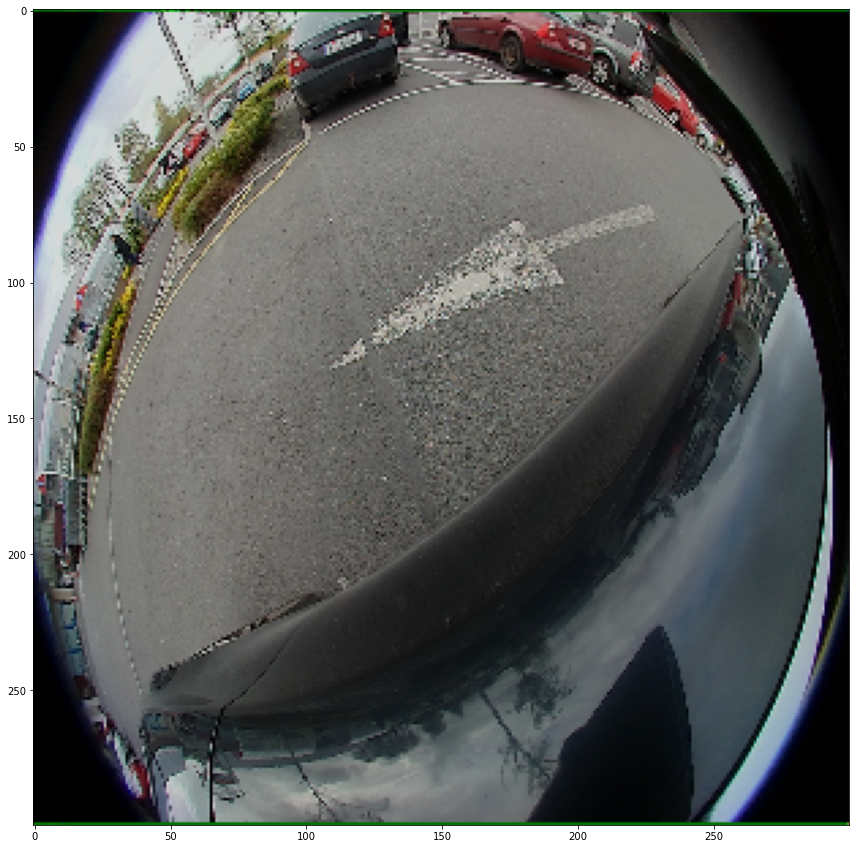

In [8]:
plt.figure(figsize=(15, 15))

plt.imshow(holdout[0][3])

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Reshape, Concatenate, MaxPooling2D, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class L2Normalization(Layer):
    """Normalizing different scale features for fusion.
    paper: https://arxiv.org/abs/1506.04579
    inputs:
        feature_map = (batch_size, feature_map_height, feature_map_width, depth)
    outputs:
        normalized_feature_map = (batch_size, feature_map_height, feature_map_width, depth)
    """
    def __init__(self, scale_factor, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
        self.scale_factor = scale_factor

    def get_config(self):
        config = super(L2Normalization, self).get_config()
        config.update({"scale_factor": self.scale_factor})
        return config

    def build(self, input_shape):
        # Network need to learn scale factor for each channel
        init_scale_factor = tf.fill((input_shape[-1],), float(self.scale_factor))
        self.scale = tf.Variable(init_scale_factor, trainable=True)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1) * self.scale

In [11]:
SSD = {
    "vgg16": {
        "img_size": 300,
        "feature_map_shapes": feature_map_shapes,
        "aspect_ratios": aspect_ratios,
    },
    "mobilenet_v2": {
        "img_size": 300,
        "feature_map_shapes": [19, 10, 5, 3, 2, 1],
        "aspect_ratios": [[1., 2., 1./2.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2.],
                         [1., 2., 1./2.]],
    }
}

def get_hyper_params(backbone, **kwargs):
    """Generating hyper params in a dynamic way.
    inputs:
        **kwargs = any value could be updated in the hyper_params
    outputs:
        hyper_params = dictionary
    """
    hyper_params = SSD[backbone]
    hyper_params["iou_threshold"] = 0.5
    hyper_params["neg_pos_ratio"] = 3
    hyper_params["loc_loss_alpha"] = 1
    hyper_params["variances"] = [0.1, 0.1, 0.2, 0.2]
    for key, value in kwargs.items():
        if key in hyper_params and value:
            hyper_params[key] = value
    #
    return hyper_params

In [12]:
hyper_params = get_hyper_params('vgg16')
hyper_params['total_labels'] = 6

In [13]:
scale_factor = 20.0
reg_factor = 5e-4
total_labels = hyper_params["total_labels"]
# +1 for ratio 1
len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Activation

class HeadWrapper(Layer):
    """Merging all feature maps for detections.
    inputs:
        conv4_3 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv4_3 shape => (38 x 38 x 4) = 5776
        conv7 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv7 shape => (19 x 19 x 6) = 2166
        conv8_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv8_2 shape => (10 x 10 x 6) = 600
        conv9_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv9_2 shape => (5 x 5 x 6) = 150
        conv10_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv10_2 shape => (3 x 3 x 4) = 36
        conv11_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv11_2 shape => (1 x 1 x 4) = 4
                                           Total = 8732 default box
    outputs:
        merged_head = (batch_size, total_prior_boxes, last_dimension)
    """

    def __init__(self, last_dimension, **kwargs):
        super(HeadWrapper, self).__init__(**kwargs)
        self.last_dimension = last_dimension

    def get_config(self):
        config = super(HeadWrapper, self).get_config()
        config.update({"last_dimension": self.last_dimension})
        return config

    def call(self, inputs):
        last_dimension = self.last_dimension
        batch_size = tf.shape(inputs[0])[0]
        outputs = []
        for conv_layer in inputs:
#             k_1 = conv_layer.shape[1]
#             k_2 = conv_layer.shape[2]
#             k_3 = conv_layer.shape[3]
#             print(k_1, k_2, k_3)
#             print(conv_layer.shape, last_dimension, tf.reshape(conv_layer, (batch_size, (k_1 * k_2 * k_3) // last_dimension, last_dimension)).shape)
#             outputs.append( tf.reshape(conv_layer, (batch_size, (k_1 * k_2 * k_3) // last_dimension, last_dimension)) )
            outputs.append(tf.reshape(conv_layer, (batch_size, -1, last_dimension)))
        #
        return tf.concat(outputs, axis=1)

def get_head_from_outputs(hyper_params, outputs):
    """Generating ssd bbox delta and label heads.
    inputs:
        hyper_params = dictionary
        outputs = list of ssd layers output to be used for prediction
    outputs:
        pred_deltas = merged outputs for bbox delta head
        pred_labels = merged outputs for bbox label head
    """
    total_labels = hyper_params["total_labels"]
    # +1 for ratio 1
    len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]
    labels_head = []
    boxes_head = []
    for i, output in enumerate(outputs):
        aspect_ratio = len_aspect_ratios[i]
        labels_head.append(Conv2D(aspect_ratio * total_labels, (3, 3), padding="same", name="{}_conv_label_output".format(i+1))(output))
        boxes_head.append(Conv2D(aspect_ratio * 4, (3, 3), padding="same", name="{}_conv_boxes_output".format(i+1))(output))
    #
    pred_labels = HeadWrapper(total_labels, name="labels_head")(labels_head)
    pred_labels = Activation("softmax", name="conf")(pred_labels)
    #
    pred_deltas = HeadWrapper(4, name="loc")(boxes_head)
    return pred_deltas, pred_labels

In [15]:
l2_reg = l2_regularization = 0.0005
n_classes = 6
n_boxes = [4, 6, 6, 6, 4, 4]

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, 
                   input_shape=(300, 300, 3))

conv4_3 = base_model.get_layer('block4_conv3').output

pool5 = base_model.get_layer('block4_pool').output

In [19]:
fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)


# Feed conv4_3 into the L2 normalization layer
conv4_3_norm = L2Normalization(scale_factor=20, name='conv4_3_norm')(conv4_3)

### Build the convolutional predictor layers on top of the base network

# We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
# Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
# We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
# Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)


In [20]:
conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)

conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)

mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

In [22]:
input = base_model.input

ssd_VGG16 = Model(inputs=input, outputs=[mbox_loc, mbox_conf_softmax])

In [23]:
ssd_VGG16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 300, 300, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 300, 300, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

                                                                                                  
 conv6_2_mbox_loc (Conv2D)      (None, 9, 9, 24)     110616      ['conv6_2[0][0]']                
                                                                                                  
 conv7_2_mbox_loc (Conv2D)      (None, 5, 5, 24)     55320       ['conv7_2[0][0]']                
                                                                                                  
 conv8_2_mbox_loc (Conv2D)      (None, 3, 3, 16)     36880       ['conv8_2[0][0]']                
                                                                                                  
 conv9_2_mbox_loc (Conv2D)      (None, 1, 1, 16)     36880       ['conv9_2[0][0]']                
                                                                                                  
 conv4_3_norm_mbox_conf_reshape  (None, 5476, 6)     0           ['conv4_3_norm_mbox_conf[0][0]'] 
  (Reshape

In [25]:
loss = SSDLoss()

In [26]:
i = 0
for d in dg:
    holdout = d
    pred = ssd_VGG16.predict(holdout[0])
    loc_los = loss.localization_loss(holdout[1][0], pred[0])
    conf_loss = loss.confidence_loss(holdout[1][1], pred[1])
    print(tf.reduce_sum(holdout[1][1][:, :, 1:], axis = 1))
    print( 'loc_los: ', tf.reduce_sum(loc_los, axis = 1) )
    print( 'conf_loss: ', tf.reduce_sum(conf_loss, axis = 1) )
    print('-'*30)
    i+=1
    if i > 10:
        break

1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[29.  0.  0.  0.  0.]
 [23.  0.  4.  2.  1.]
 [32.  1.  0.  0.  1.]
 [35.  4.  0.  0.  0.]
 [18.  2.  5.  0.  0.]
 [ 8.  1.  1.  0.  0.]
 [12.  9.  1.  0.  0.]
 [ 3.  5.  5.  0.  0.]
 [27.  1.  0.  0.  0.]
 [19.  5.  0.  0.  0.]
 [26.  2.  1.  0.  1.]
 [33.  3.  0.  0.  1.]
 [ 8. 21.  1.  0.  0.]
 [31.  0.  0.  0.  0.]
 [11.  2.  1.  0.  0.]
 [28.  0.  0.  0.  0.]], shape=(16, 5), dtype=float32)
loc_los:  tf.Tensor(
[1.0016804  0.7164948  1.1905931  0.723385   0.44219708 0.6875153
 0.61914307 0.4170422  0.54177856 0.9262855  0.9697014  0.9328256
 0.8243315  0.72874    0.48722184 0.6479025 ], shape=(16,), dtype=float32)
conf_loss:  tf.Tensor(
[6.891624  6.3387647 6.9900694 5.6585155 6.320671  6.2720633 5.8473415
 6.4704795 6.010437  6.4647584 7.062579  5.85287   6.281795  6.0662713
 6.471089  5.9120617], shape=(16,), dtype=float32)
------------------------------
1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[4

1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[24.  1.  0.  0.  0.]
 [ 9.  1.  0.  0.  4.]
 [11.  0.  4.  0.  0.]
 [52.  4. 52.  0.  0.]
 [19.  3.  6.  0.  0.]
 [10.  0.  2.  0.  2.]
 [ 8.  2.  0.  0.  0.]
 [34.  9.  0.  0.  0.]
 [ 7.  6. 11.  0.  2.]
 [27.  0.  1.  0.  0.]
 [ 7. 12.  0.  0.  2.]
 [21.  0.  1.  0.  2.]
 [ 9.  0.  0.  0.  0.]
 [27.  4.  2.  0.  1.]
 [19.  1.  9.  0.  1.]
 [31.  0.  9.  0.  0.]], shape=(16, 5), dtype=float32)
loc_los:  tf.Tensor(
[0.70372534 0.7175305  0.8098769  1.0833535  0.9008934  0.69108963
 0.43957624 0.60463154 0.8181383  0.6954235  0.8839916  0.57420975
 0.32126182 0.55736506 0.9589652  0.8225121 ], shape=(16,), dtype=float32)
conf_loss:  tf.Tensor(
[6.1799917 6.1725907 6.9037943 5.2020884 6.7745605 8.169187  5.7201176
 5.5207486 6.5046062 6.6097145 6.144623  6.1510825 7.8571334 5.800288
 6.478657  6.014418 ], shape=(16,), dtype=float32)
------------------------------
1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[

In [27]:
ssd_VGG16.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss=[loss.localization_loss, loss.confidence_loss])

In [ ]:
ssd_VGG16.fit(dg, epochs = 10)

Epoch 1/10
15/15 [==============================] - 197s 13s/step - loss: 3.0949 - mbox_loc_loss: 2.9513e-05 - mbox_conf_softmax_loss: 3.2821e-04
Epoch 2/10
15/15 [==============================] - 188s 12s/step - loss: 1.4531 - mbox_loc_loss: 7.3203e-06 - mbox_conf_softmax_loss: 2.2208e-04
Epoch 3/10
15/15 [==============================] - 175s 12s/step - loss: 0.7111 - mbox_loc_loss: 6.1698e-06 - mbox_conf_softmax_loss: 2.1414e-04
Epoch 4/10
15/15 [==============================] - 176s 12s/step - loss: 0.3698 - mbox_loc_loss: 5.9961e-06 - mbox_conf_softmax_loss: 2.1044e-04
Epoch 5/10
15/15 [==============================] - 187s 12s/step - loss: 0.2022 - mbox_loc_loss: 6.1601e-06 - mbox_conf_softmax_loss: 2.1236e-04
Epoch 6/10
14/15 [===========================>..] - ETA: 14s - loss: 0.1171 - mbox_loc_loss: 6.1040e-06 - mbox_conf_softmax_loss: 2.0798e-04